In [1]:
# The MIT License (MIT) Copyright (c) 2025 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/32_Flow_Matching.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Flow Matching

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

torch.__version__

'2.5.1+cu124'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
batch_size = 128
img_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

In [5]:
len(train_loader.dataset)

60000

In [6]:
test_batch, test_labels = next(iter(train_loader))
test_batch.shape, test_labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

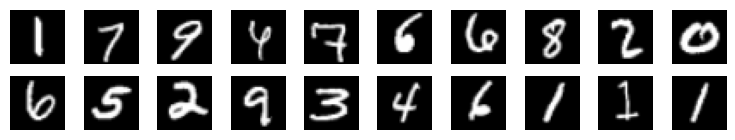

In [7]:
# Define a function to plot images with titles
def plot_batch(images):
    images = images * 0.5 + 0.5
    fig, axes = plt.subplots(2, 10, figsize=(7.5, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images and their corresponding targets
n_plot = 20
batch_images = test_batch[:n_plot]

# Plot the batch of images
plot_batch(batch_images)

## 2.- Model
### UNet

In [8]:
import torch.nn as nn
import math

In [9]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dim, scale=1.0):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.scale = scale

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_scale = math.log(10000) / half_dim
        freqs = torch.exp(torch.arange(half_dim, device=device) * -emb_scale)

        # Flatten x to (B,)
        x_flat = x.view(-1) * self.scale  # shape: (B,)

        # Outer product: (B, half_dim)
        emb = torch.outer(x_flat, freqs)

        # Positional encoding: (B, dim)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        return emb  # shape: (B, dim)


In [10]:
class upBlock(nn.Module):
    def __init__(self, in_planes, out_planes, emb_dim):
        super(upBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=in_planes, 
                         num_groups=in_planes // 4),
            nn.SiLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_planes, out_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=out_planes, 
                         num_groups=out_planes // 4),
            nn.SiLU(),
        )
        self.emb = nn.Sequential(
            nn.Linear(emb_dim, out_planes),
            nn.SiLU(),
        )

    def forward(self, x, t):
        x = self.conv1(x) + x
        return self.conv2(x) + self.emb(t)[:, :, None, None]


class DownBlock(nn.Module):
    def __init__(self, in_planes, out_planes, emb_dim):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=in_planes, 
                         num_groups=in_planes // 4),
            nn.SiLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.GroupNorm(num_channels=out_planes, 
                         num_groups=out_planes // 4),
            nn.SiLU(),
        )
        self.emb = nn.Sequential(
            nn.Linear(emb_dim, out_planes),
            nn.SiLU(),
        )

    def forward(self, x, t):
        x = self.conv1(x) + x
        return self.conv2(x) + self.emb(t)[:, :, None, None]


class UNet(nn.Module):
    def __init__(self, n_channels=64, emb_dim=64, norm_num_groups=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.inp = nn.Sequential(
            nn.Conv2d(1, n_channels, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=n_channels, 
                         num_groups=n_channels // 4),
            nn.SiLU(),
        )

        self.down1 = DownBlock(n_channels, n_channels*2, emb_dim)
        self.down2 = DownBlock(n_channels*2, n_channels*4, emb_dim)

        self.up1 = upBlock(n_channels*4, n_channels*2, emb_dim)
        self.up2 = upBlock(n_channels*4, n_channels, emb_dim)

        self.out = nn.Sequential(
            nn.GroupNorm(num_channels=n_channels, 
                         num_groups=n_channels // 4),
            nn.SiLU(),
            nn.Conv2d(n_channels, 1, 3, 1, 1, bias=False),
        )

        self.emb = nn.Sequential(
            PositionalEmbedding(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x, t):
        B = x.shape[0]
        emb = self.emb(t)
        x1 = self.inp(x)
        x2 = self.down1(x1, emb)
        x3 = self.down2(x2, emb)

        x = self.up1(x3, emb)
        x = self.up2(torch.concat([x, x2], 1), emb)
        x = self.out(x)
        return x


unet = UNet(64, 64)
noise_test = torch.randn(test_batch.shape)
t_test = torch.ones(test_batch.shape[0], 1)
out_batch = unet(noise_test, t_test)
out_batch.shape, t_test.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128, 1]))

### Diffusion

In [11]:
optimizer = optim.Adam(unet.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [13]:
unet.to(device)

UNet(
  (inp): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (2): SiLU()
  )
  (down1): DownBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (emb): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SiLU()
    )
  )
  (down2): DownBlock(
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=

## 3.- Training

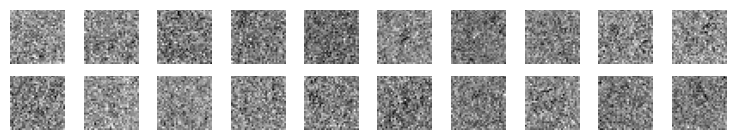

In [14]:
from torchdiffeq import odeint

class ODEFunction(torch.nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, t, x):
        B = x.shape[0]
        device = x.device
        t_tensor = torch.full((B, 1), float(t), device=device)
        return self.unet(x, t_tensor)

def sample(unet, device, num_samples, image_shape, seed=None):
    unet.eval()
    with torch.no_grad():
        # Optionally seed RNG for reproducibility
        if seed is not None:
            with torch.random.fork_rng(devices=[device]):
                torch.manual_seed(seed)
                x0 = torch.randn(num_samples, *image_shape, device=device)
        else:
            x0 = torch.randn(num_samples, *image_shape, device=device)

        ode_func = ODEFunction(unet)
        t_span = torch.tensor([0.0, 1.0], device=device)
        x1 = odeint(
            ode_func, x0, t_span,
            atol=1e-4,
            rtol=1e-4,
            method="dopri5"
        )[1]
    return x1
    
seed = 42
samples = sample(unet, device, 20, (1, 32, 32), seed=seed)
plot_batch(samples.cpu())

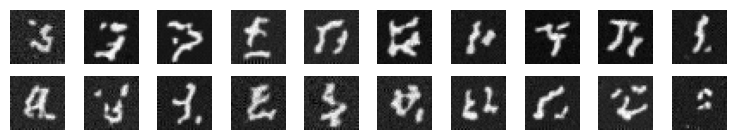

Epoch [0/40], Loss: 0.1876
Time for epoch 0 is 13.7781 sec
Epoch [1/40], Loss: 0.1668
Time for epoch 1 is 13.6506 sec
Epoch [2/40], Loss: 0.1697
Time for epoch 2 is 13.4989 sec
Epoch [3/40], Loss: 0.1603
Time for epoch 3 is 13.4838 sec
Epoch [4/40], Loss: 0.1476
Time for epoch 4 is 13.7878 sec
Epoch [5/40], Loss: 0.1575
Time for epoch 5 is 13.7380 sec
Epoch [6/40], Loss: 0.1384
Time for epoch 6 is 13.7158 sec
Epoch [7/40], Loss: 0.1448
Time for epoch 7 is 13.6183 sec
Epoch [8/40], Loss: 0.1643
Time for epoch 8 is 13.7469 sec
Epoch [9/40], Loss: 0.1296
Time for epoch 9 is 13.7281 sec


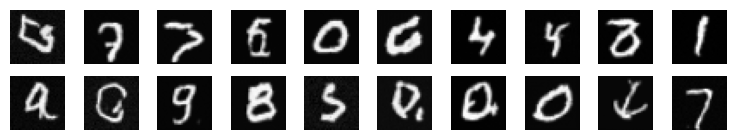

Epoch [10/40], Loss: 0.1325
Time for epoch 10 is 14.2708 sec
Epoch [11/40], Loss: 0.1278
Time for epoch 11 is 13.7258 sec
Epoch [12/40], Loss: 0.1228
Time for epoch 12 is 13.7242 sec
Epoch [13/40], Loss: 0.1329
Time for epoch 13 is 13.5031 sec
Epoch [14/40], Loss: 0.1560
Time for epoch 14 is 13.5221 sec
Epoch [15/40], Loss: 0.1462
Time for epoch 15 is 13.5367 sec
Epoch [16/40], Loss: 0.1290
Time for epoch 16 is 13.5480 sec
Epoch [17/40], Loss: 0.1446
Time for epoch 17 is 13.5424 sec
Epoch [18/40], Loss: 0.1259
Time for epoch 18 is 13.5448 sec
Epoch [19/40], Loss: 0.1336
Time for epoch 19 is 13.5558 sec


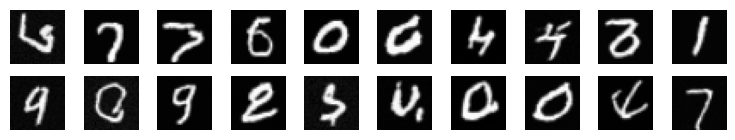

Epoch [20/40], Loss: 0.1300
Time for epoch 20 is 14.0594 sec
Epoch [21/40], Loss: 0.1366
Time for epoch 21 is 13.5722 sec
Epoch [22/40], Loss: 0.1421
Time for epoch 22 is 13.5419 sec
Epoch [23/40], Loss: 0.1420
Time for epoch 23 is 13.5480 sec
Epoch [24/40], Loss: 0.1409
Time for epoch 24 is 13.5435 sec
Epoch [25/40], Loss: 0.1422
Time for epoch 25 is 13.5584 sec
Epoch [26/40], Loss: 0.1241
Time for epoch 26 is 13.5577 sec
Epoch [27/40], Loss: 0.1286
Time for epoch 27 is 13.5540 sec
Epoch [28/40], Loss: 0.1337
Time for epoch 28 is 13.5546 sec
Epoch [29/40], Loss: 0.1320
Time for epoch 29 is 13.5496 sec


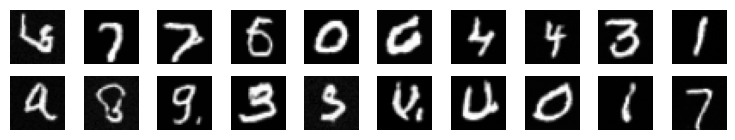

Epoch [30/40], Loss: 0.1318
Time for epoch 30 is 13.9510 sec
Epoch [31/40], Loss: 0.1202
Time for epoch 31 is 13.5641 sec
Epoch [32/40], Loss: 0.1560
Time for epoch 32 is 13.5397 sec
Epoch [33/40], Loss: 0.1406
Time for epoch 33 is 13.5747 sec
Epoch [34/40], Loss: 0.1257
Time for epoch 34 is 13.8466 sec
Epoch [35/40], Loss: 0.1382
Time for epoch 35 is 13.9031 sec
Epoch [36/40], Loss: 0.1238
Time for epoch 36 is 13.7136 sec
Epoch [37/40], Loss: 0.1229
Time for epoch 37 is 13.7188 sec
Epoch [38/40], Loss: 0.1409
Time for epoch 38 is 13.9727 sec
Epoch [39/40], Loss: 0.1183
Time for epoch 39 is 13.7298 sec


In [15]:
import torch.nn.functional as F
from tqdm import tqdm

def interpolate(x0, x1, t):
    return (1 - t) * x0 + t * x1

def interpolate_derivative(x0, x1):
    return x1 - x0

def train_step(unet, batch, optimizer, device):
    x1 = batch.to(device)  
    batch_size = x1.size(0)
    x0 = torch.randn_like(x1) 

    t = torch.rand(batch_size, 1, device=device)

    # Expand for interpolation
    t_expanded = t.view(batch_size, 1, 1, 1)
    xt = interpolate(x0, x1, t_expanded)

    # Target velocity
    vt = interpolate_derivative(x0, x1)

    # Predict velocity
    vt_pred = unet(xt, t) 

    loss = F.mse_loss(vt_pred, vt)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def train(unet, dataloader, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        start = time.time()
        unet.train()
        for batch, _ in dataloader:
            loss = train_step(unet, batch, optimizer, device)
        if epoch % 10 == 0:
            samples = sample(unet, device, 20, (1, 32, 32), seed=seed)
            plot_batch(samples.cpu())
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss:.4f}")
        print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec')


train(unet, train_loader, optimizer, device, num_epochs=40)

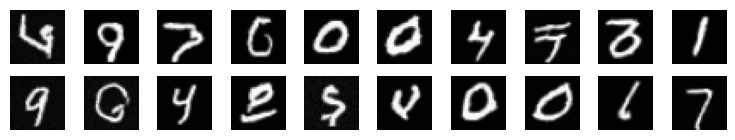

In [16]:
samples = sample(unet, device, 20, (1, 32, 32), seed=seed)
plot_batch(samples.cpu())

In [17]:
@torch.no_grad()
def sample_flow_matching(unet, num_samples, device, num_steps=100):
    unet.eval()
    x = torch.randn(num_samples, 1, 32, 32).to(device)  
    t_steps = torch.linspace(1.0, 0.0, num_steps + 1, device=device) 

    for i in tqdm(range(num_steps)):
        t_curr = t_steps[i].repeat(num_samples, 1)  

        dt = t_steps[i+1] - t_steps[i]

        # Predict velocity
        v = unet(x, t_curr)
        x = x - dt * v

    return x 